## Muzzle Object Detection

In [1]:
#!pip install -q faiss-cpu

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
import cv2
import torch
from torch import nn
import torchvision
from transformers import  DetrFeatureExtractor, DetrForObjectDetection
import faiss

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

In [4]:
model_path = "C:/Users/Acre-R/OneDrive - Acre Africa/Documents/Muzzle Project/detrmodel"
feature_extractor = DetrFeatureExtractor.from_pretrained(model_path)
model = DetrForObjectDetection.from_pretrained(model_path)
model = model.to(device)

C:\Users\Acre-R\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\detr\feature_extraction_detr.py:38: FutureWarning: The class DetrFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DetrImageProcessor instead.
  warnings.warn(


In [5]:
def predict_object_in_image(img_path, model, feature_extractor, device, threshold=0.7):
    # Load and preprocess the image
    def load_and_preprocess_image(img_path):
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = np.array(img, dtype=np.float32) / 255.0
        return img_array

    # Preprocess image
    image = load_and_preprocess_image(img_path)

    # Feature extraction and model inference
    with torch.no_grad():
        inputs = feature_extractor(images=[image], return_tensors="pt")
        outputs = model(**inputs.to(device))
        
        # Get the image size
        image_pil = Image.open(img_path)
        image_size = image_pil.size  
        target_sizes = torch.tensor([[image_size[1], image_size[0]]])  # [height, width]

        # Post-process object detection results
        results = feature_extractor.post_process_object_detection(outputs, threshold=threshold, target_sizes=target_sizes)
        results = results[0]

    # Iterate over the results and print the detections
    detections = []
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
        box = [round(i, 2) for i in box.tolist()]
        detection_info = {
            "label": model.config.id2label[label.item()],
            "confidence": round(score.item(), 3),
            "box": box
        }
        detections.append(detection_info)

    return detections

### Example 1

In [6]:
img_path = "C:/Users/Acre-R/OneDrive - Acre Africa/Documents/Muzzle Project/acre examples/temp_image_file8274024553096716114.png"

#img_path = "C:/Users/Acre-R/OneDrive - Acre Africa/Documents/Muzzle Project/acre examples/muzzle_2.jpg"
detections = predict_object_in_image(img_path, model, feature_extractor, device)
#print(detections)

if not detections:
    print("No objects detected.")
elif len(detections) > 1:
    best_detection = max(detections, key=lambda x: x['confidence'])
    print(f"Detected {best_detection['label']} with confidence {best_detection['confidence']} at location {best_detection['box']}")
else:
    detection = detections[0]  
    print(f"Detected {detection['label']} with confidence {detection['confidence']} at location {detection['box']}")

Detected Muzzle with confidence 0.731 at location [819.06, 1082.91, 2472.36, 2400.77]


In [7]:
def visualize_boxes_on_image(img_path, detections, model):
    """
    Visualizes the bounding boxes on the image along with the labels and confidence scores.
    
    Parameters:
    - img_path: str, path to the input image.
    - detections: list, contains dictionaries with 'label', 'confidence', and 'box' for each detection.
    - model: the model used for predictions, it should have 'id2label' mapping.
    
    Returns:
    - None, displays the image with bounding boxes.
    """
    # Open the image
    image_pil = Image.open(img_path)
    
    # Convert image to a format that OpenCV can draw on
    image = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    
    # Loop over each detection result
    for detection in detections:
        label = detection['label']
        confidence = detection['confidence']
        box = detection['box']
        
        # Round the box coordinates
        box = [round(i, 2) for i in box]
        x1, y1, x2, y2 = map(int, box)

        # Draw the rectangle for the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Red box
        
        # Create the label text
        label_text = f"{label}: {round(confidence, 3)}"
        
        # Draw the label text on top of the box
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0, 0, 0), 3)  # Black, bold text
    
    # Convert back to RGB for display in PIL
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Display the image using Matplotlib
    plt.imshow(image_pil)
    plt.axis('off')  # Hide axes
    plt.show()


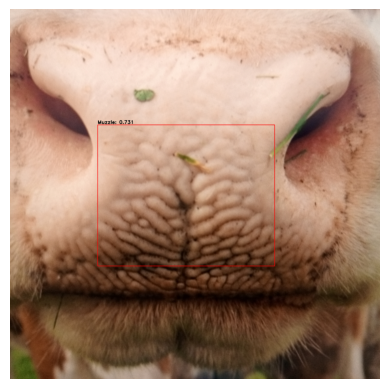

In [8]:
results = detections
visualize_boxes_on_image(img_path, results, model)

In [9]:
img = cv2.imread(img_path)
x_min, y_min, x_max, y_max = map(int, detection['box'])  
cropped_image1 = img[y_min:y_max, x_min:x_max]  

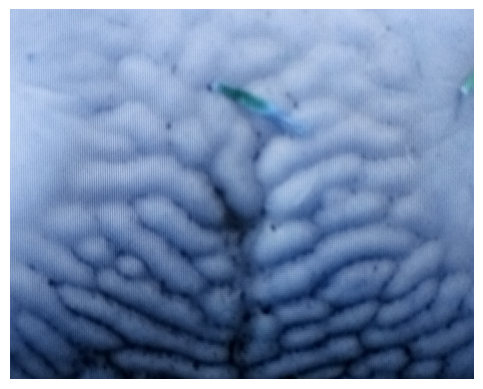

In [10]:
plt.imshow(cropped_image1)
plt.axis('off')  # Optional: Hide axis labels for better visualization
plt.show()


### Example 2

In [31]:
img_path1 = "C:/Users/Acre-R/OneDrive - Acre Africa/Documents/Muzzle Project/acre examples/temp_image_file978080460442064626.png"
#img_path1 = "C:/Users/Acre-R/OneDrive - Acre Africa/Documents/Muzzle Project/acre examples/temp_image_file981887699296208743.png"
#img_path = "C:/Users/Acre-R/OneDrive - Acre Africa/Documents/Muzzle Project/acre examples/muzzle_2.jpg"
detections1 = predict_object_in_image(img_path1, model, feature_extractor, device)
#print(detections)

if not detections1:
    print("No objects detected.")
elif len(detections1) > 1:
    best_detection1 = max(detections1, key=lambda x: x['confidence'])
    print(f"Detected {best_detection1['label']} with confidence {best_detection1['confidence']} at location {best_detection1['box']}")
else:
    detection1 = detections1[0]  
    print(f"Detected {detection1['label']} with confidence {detection1['confidence']} at location {detection1['box']}")

Detected Muzzle with confidence 0.974 at location [859.69, 1437.48, 3319.63, 3051.87]


In [32]:
def visualize_boxes_on_image(img_path, detections, model):
    """
    Visualizes the bounding boxes on the image along with the labels and confidence scores.
    
    Parameters:
    - img_path: str, path to the input image.
    - detections: list, contains dictionaries with 'label', 'confidence', and 'box' for each detection.
    - model: the model used for predictions, it should have 'id2label' mapping.
    
    Returns:
    - None, displays the image with bounding boxes.
    """
    # Open the image
    image_pil = Image.open(img_path)
    
    # Convert image to a format that OpenCV can draw on
    image = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)
    
    # Loop over each detection result
    for detection in detections:
        label = detection['label']
        confidence = detection['confidence']
        box = detection['box']
        
        # Round the box coordinates
        box = [round(i, 2) for i in box]
        x1, y1, x2, y2 = map(int, box)

        # Draw the rectangle for the bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), 3)  # Red box
        
        # Create the label text
        label_text = f"{label}: {round(confidence, 3)}"
        
        # Draw the label text on top of the box
        cv2.putText(image, label_text, (x1, y1 - 10), cv2.FONT_HERSHEY_DUPLEX, 1.5, (0, 0, 0), 3)  # Black, bold text
    
    # Convert back to RGB for display in PIL
    image_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Display the image using Matplotlib
    plt.imshow(image_pil)
    plt.axis('off')  # Hide axes
    plt.show()


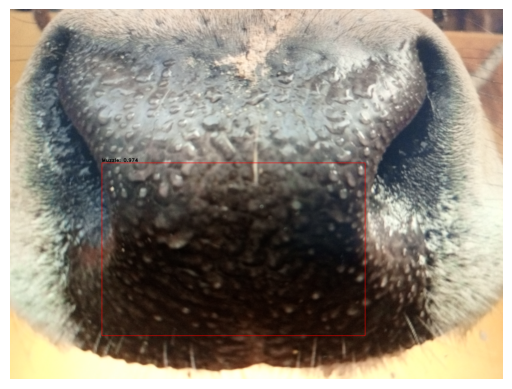

In [33]:
results = detections1
visualize_boxes_on_image(img_path1, results, model)

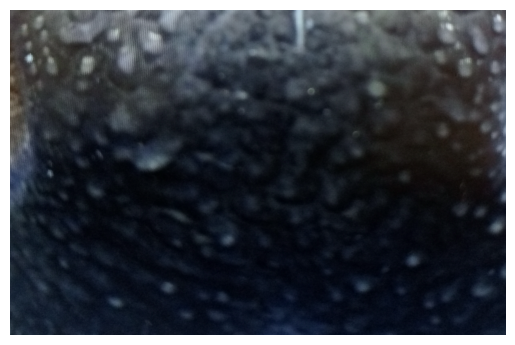

In [34]:
img1 = cv2.imread(img_path1)
x_min, y_min, x_max, y_max = map(int, detection1['box'])  # Convert to integers
cropped_image2 = img1[y_min:y_max, x_min:x_max]  # Crop the image

plt.imshow(cropped_image2)
plt.axis('off')  # Optional: Hide axis labels for better visualization
plt.show()

## Feature Extraction using SIFT/OBR

In [35]:
print(cropped_image2.shape)

(1614, 2460, 3)


### Similarity score using SIFT